## This program implements the Quantum Haar Wavelet transform on Qiskit. Author: Dhruv Bhatnagar.

#### Importing standard Qiskit libraries and configuring account

In [106]:
%matplotlib inline

import numpy as np
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import QuantumRegister, ClassicalRegister
import qiskit.extensions.standard.swap

# Loading the IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-06-07 11:29:22,476: Credentials are already in use. The existing account in the session will be replaced.


#### The below cell initializes a quantum circuit consisting of 5 principal (data) qubits, 3 ancillary qubits and 5 classical bits. At the end of this cell, the multi-qubit controlled Hadamard gates required by the wavelet transform would have been implemented (for which the ancillary qubits are required).

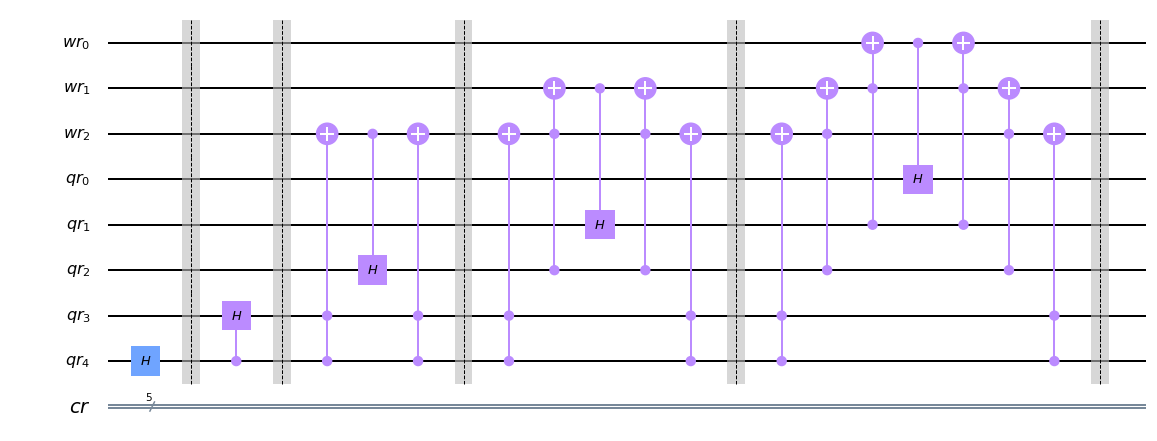

In [107]:
# Build the quantum circuit
# n = 5: number of qubits

q = QuantumRegister(5, name = 'qr')
w = QuantumRegister(3, name = 'wr')
c = ClassicalRegister(5, name = 'cr')

circ = QuantumCircuit(w, q, c)

circ.h(q[4])
circ.barrier()
circ.ch(q[4],q[3])
circ.barrier()
circ.ccx(q[4],q[3],w[2])
circ.ch(w[2],q[2])
circ.ccx(q[4],q[3],w[2])
circ.barrier()
circ.ccx(q[4],q[3],w[2])
circ.ccx(q[2],w[2],w[1])
circ.ch(w[1],q[1])
circ.ccx(q[2],w[2],w[1])
circ.ccx(q[4],q[3],w[2])
circ.barrier()
circ.ccx(q[4],q[3],w[2])
circ.ccx(q[2],w[2],w[1])
circ.ccx(q[1],w[1],w[0])
circ.ch(w[0],q[0])
circ.ccx(q[1],w[1],w[0])
circ.ccx(q[2],w[2],w[1])
circ.ccx(q[4],q[3],w[2])
circ.barrier()
#at this point, the controlled Hadamard gates have been implemented.

circ.draw(output='mpl')

#### Now, we need to implement the perfect shuffle gates for the transform. We need the pi_4, pi_8, pi_16, pi_32 gates (See references). The 2-qubit swap gate has been implemented in qiskit.extensions.standard.swap.

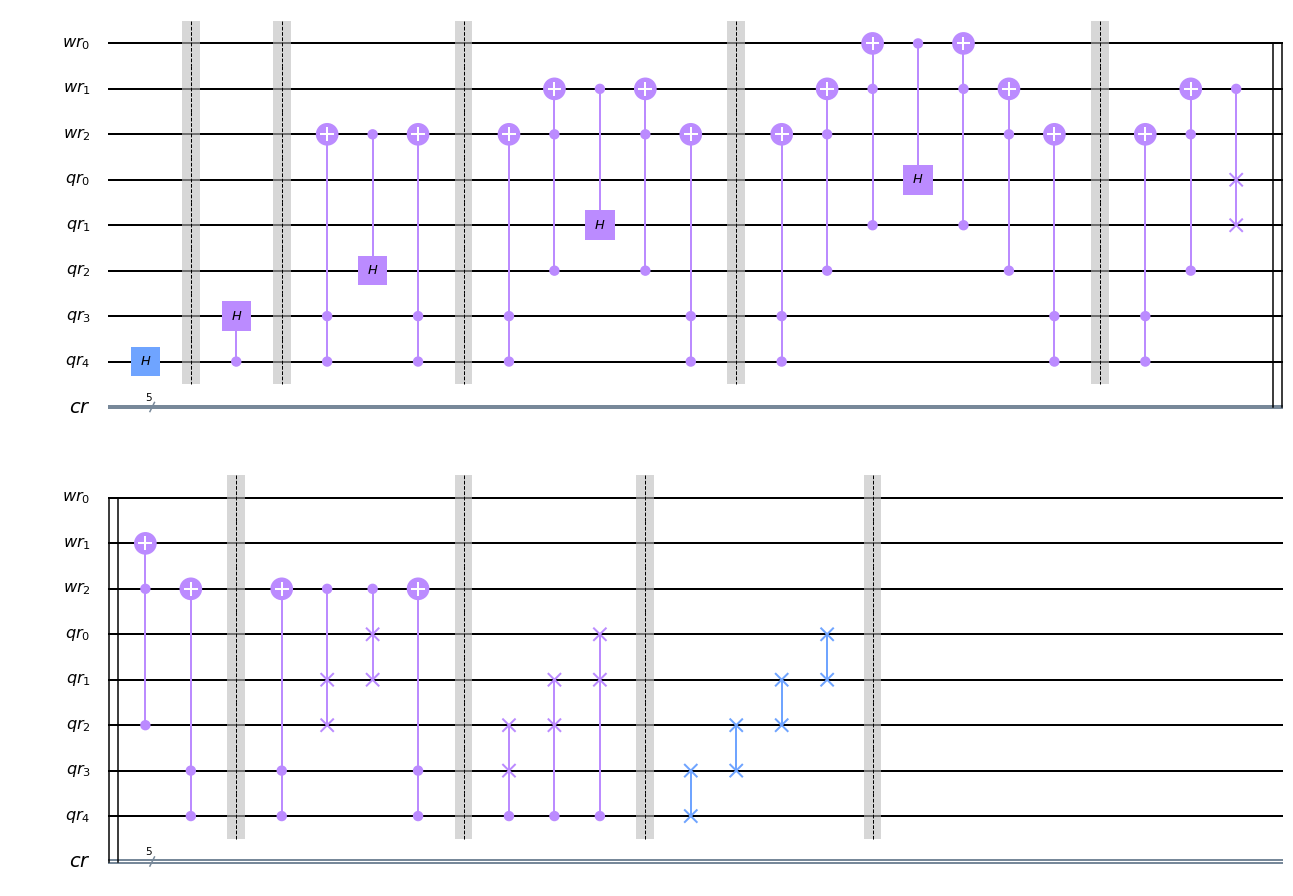

In [108]:
# implementation of pi_4
circ.ccx(q[4],q[3],w[2])
circ.ccx(q[2],w[2],w[1])
circ.cswap(w[1],q[1],q[0])
circ.ccx(q[2],w[2],w[1])
circ.ccx(q[4],q[3],w[2])
circ.barrier()
# implementation of pi_8
circ.ccx(q[4],q[3],w[2])
circ.cswap(w[2],q[2],q[1])
circ.cswap(w[2],q[1],q[0])
circ.ccx(q[4],q[3],w[2])
circ.barrier()
# implementation of pi_16
circ.cswap(q[4],q[3],q[2])
circ.cswap(q[4],q[2],q[1])
circ.cswap(q[4],q[1],q[0])
circ.barrier()
# implementation of pi_32
circ.swap(q[4],q[3])
circ.swap(q[3],q[2])
circ.swap(q[2],q[1])
circ.swap(q[1],q[0])
circ.barrier()

circ.draw(output='mpl')

#### The next cell simulates the state vector of the quantum circuit without measurement. Select the StatevectorSimulator from the Aer provider to get the statevector at output of this circuit

In [109]:
simulator_sv = Aer.get_backend('statevector_simulator')
# Execute and get counts
result_sv = execute(circ, simulator_sv).result()
statevector_sv = result_sv.get_statevector(circ)
print(statevector_sv)

# Un-comment the next two lines to visualise the quantum state
#plot_histogram(statevector_sv.get_counts(circ))
#plot_state_city(statevector_sv)

[ 7.07106781e-01-1.40061847e-16j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  5.00000000e-01-1.06113134e-16j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  2.50383811e-17-5.55111512e-17j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  3.53553391e-01-3.24733521e-17j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.000000

#### Now, the measurement outcomes are simulated by measuring the qubits, using openQASM backend.

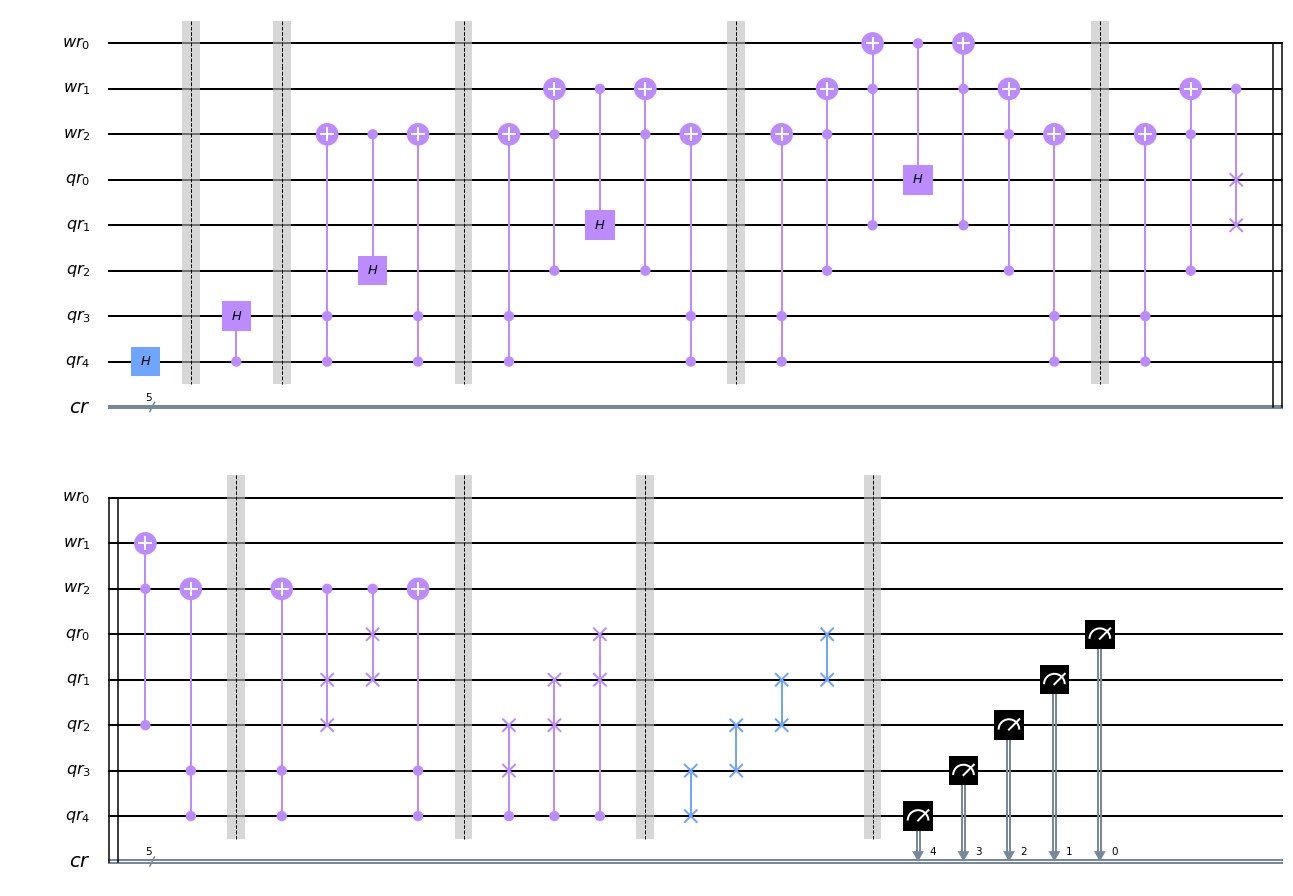

In [110]:
circ.measure(q[4],c[4])
circ.measure(q[3],c[3])
circ.measure(q[2],c[2])
circ.measure(q[1],c[1])
circ.measure(q[0],c[0])

circ.draw(output='mpl')

#### Now for the measurement simulation for 1024 runs/shots.

In [111]:
from qiskit import BasicAer
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(circ, backend_sim, shots=1024)
result_sim = job_sim.result()
count = result_sim.get_counts(circ)
print(count)

{'00111': 50, '00000': 516, '00011': 128, '01111': 26, '00001': 269, '11111': 35}


#### The measurement results can be visualised in the following histogram.

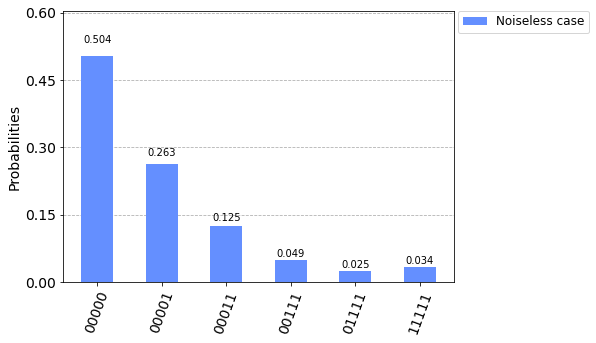

In [112]:
legend = ['Noiseless case']
plot_histogram(count, legend=legend)

#### The next cell executes the above circuit on an actual quantum backend.

In [113]:
#backend_qc = IBMQ.get_backend('ibmq_16_melbourne')
backend_qc = provider.get_backend('ibmq_16_melbourne')
print(backend_qc)
job_qc = execute(circ, backend_qc, shots=32)
result_qc = job_qc.result()
count_qc = result_qc.get_counts(circ)
print(count_qc)

ibmq_16_melbourne
{'01000': 4, '01101': 1, '11100': 1, '00011': 3, '00110': 1, '01011': 2, '10001': 1, '01001': 2, '00000': 6, '11000': 1, '00101': 1, '01110': 2, '01100': 3, '00001': 3, '00010': 1}


#### The measurement results can be visualised in the following histogram.

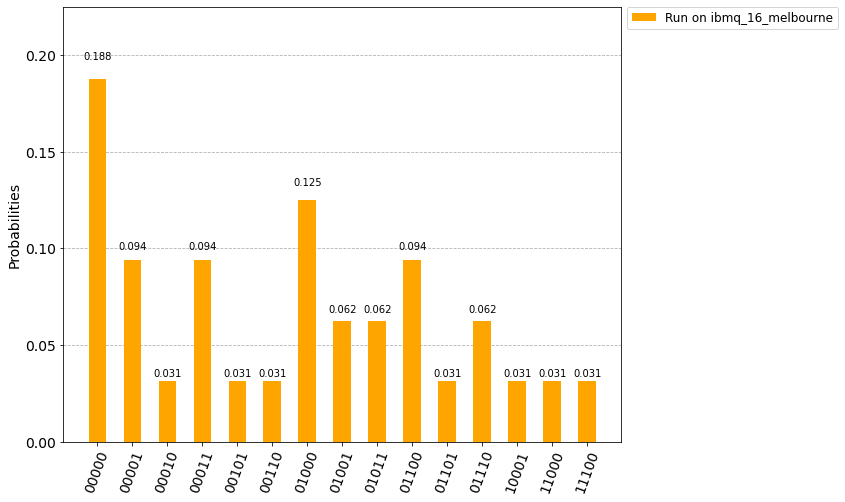

In [114]:
legend = ['Run on ibmq_16_melbourne']
plot_histogram(count_qc, legend=legend, color='orange', figsize=(10,8))

#### In the next few cells, the same circuit is simulated with a noise model applied. This helps to analyze the output in both the noiseless and the noisy cases.

In [115]:
from qiskit.providers.aer import QasmSimulator
print(QasmSimulator().configuration().basis_gates)

['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror']


#### The proposed noise model is:
#### 1. depolarizing_error in every qubit in q register only, with a uniform random damping parameter in the data qubits
#### 2. measurement error with probability 0.1 of inverting the output, which is a pauli_error 
#### 3. additionally, each of the (single qubit) hadamard gates adds a phase flip error (a pauli_error) with a probability of p_phase_flip_h

In [116]:
# import the libraries required to carry out a noisy simulation
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error

#### Creating and applying the noise model

In [117]:
#error probabilities
p_meas = 0.05
p_depolarizing = 0.001
p_phase_flip_h = 0.01

# Quantum error objects
error_depolarizing_1_qubit = depolarizing_error(p_depolarizing, 1) # 5 is the number of qubits
error_depolarizing_2_qubit = error_depolarizing_1_qubit.tensor(error_depolarizing_1_qubit)
error_depolarizing_3_qubit = error_depolarizing_2_qubit.tensor(error_depolarizing_1_qubit)
error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
error_phase_flip_h = pauli_error([('Z', p_phase_flip_h), ('I', 1 - p_phase_flip_h)])

noise_cust = NoiseModel()
noise_cust.add_all_qubit_quantum_error(error_depolarizing_1_qubit, ['h', 'u1', 'u2', 'u3'])
noise_cust.add_all_qubit_quantum_error(error_depolarizing_2_qubit, ['cx', 'swap'])
noise_cust.add_all_qubit_quantum_error(error_depolarizing_3_qubit, ['ccx', 'cswap'])
noise_cust.add_all_qubit_quantum_error(error_meas, 'measure')
noise_cust.add_all_qubit_quantum_error(error_phase_flip_h, ['h'])

print(noise_cust)

NoiseModel:
  Basis gates: ['ccx', 'cswap', 'cx', 'h', 'id', 'swap', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'ccx', 'cx', 'measure', 'swap', 'cswap', 'u2', 'h', 'u1']
  All-qubits errors: ['h', 'u1', 'u2', 'u3', 'cx', 'swap', 'ccx', 'cswap', 'measure']


#### Now, the noisy simulation is executed, and a histogram is plotted, showing the noiseless and noisy cases.

{'10100': 1, '00011': 112, '00110': 3, '11010': 1, '11001': 1, '10110': 1, '11110': 2, '01010': 2, '10011': 6, '01111': 35, '00001': 191, '00010': 39, '00100': 34, '00111': 38, '01000': 38, '01101': 3, '10111': 6, '01011': 12, '10001': 15, '11011': 1, '10010': 2, '11111': 25, '01001': 22, '00000': 391, '10101': 2, '11000': 2, '00101': 10, '01110': 4, '01100': 2, '11101': 1, '10000': 22}


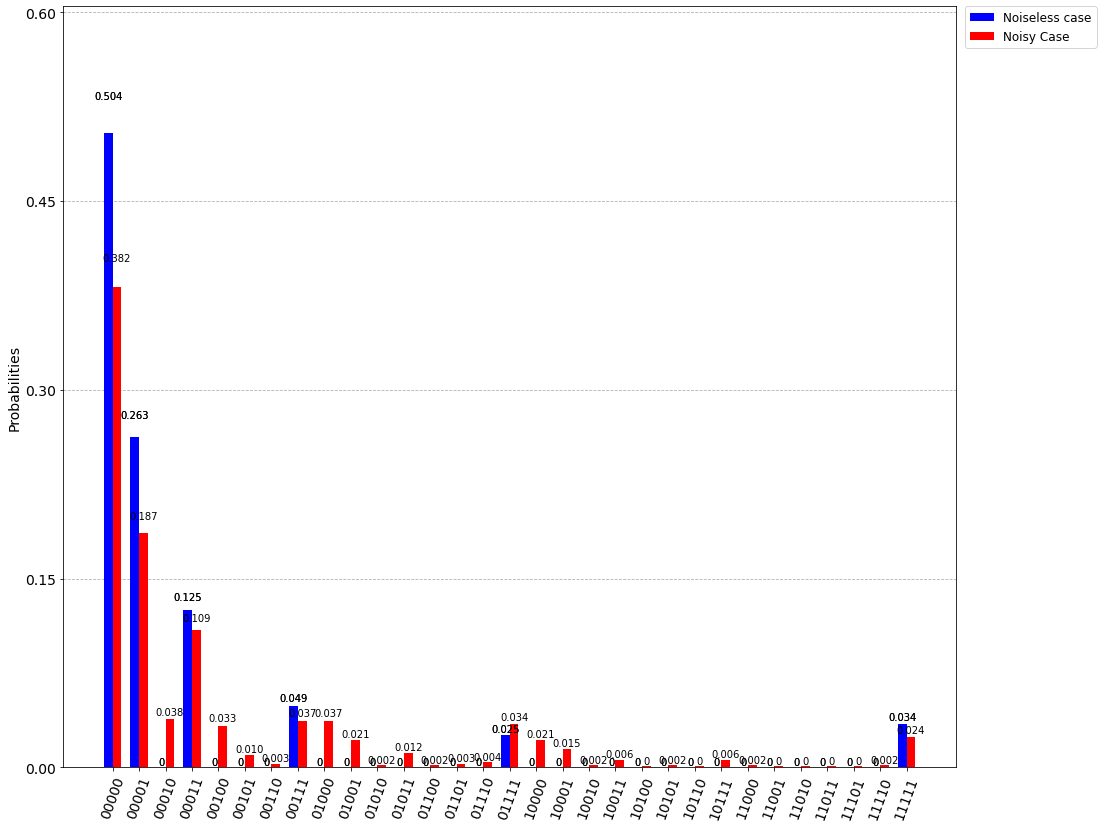

In [118]:
job_noise = execute(circ, backend_sim, shots=1024,  noise_model = noise_cust, basis_gates = noise_cust.basis_gates)
result_noise = job_noise.result()
count_noise = result_noise.get_counts(circ)
print(count_noise)
legend = ['Noiseless case', 'Noisy Case']
plot_histogram([count, count_noise], figsize=(16,14), legend=legend, color=['blue', 'red'])

#### A comparison of all 3 cases is done below:

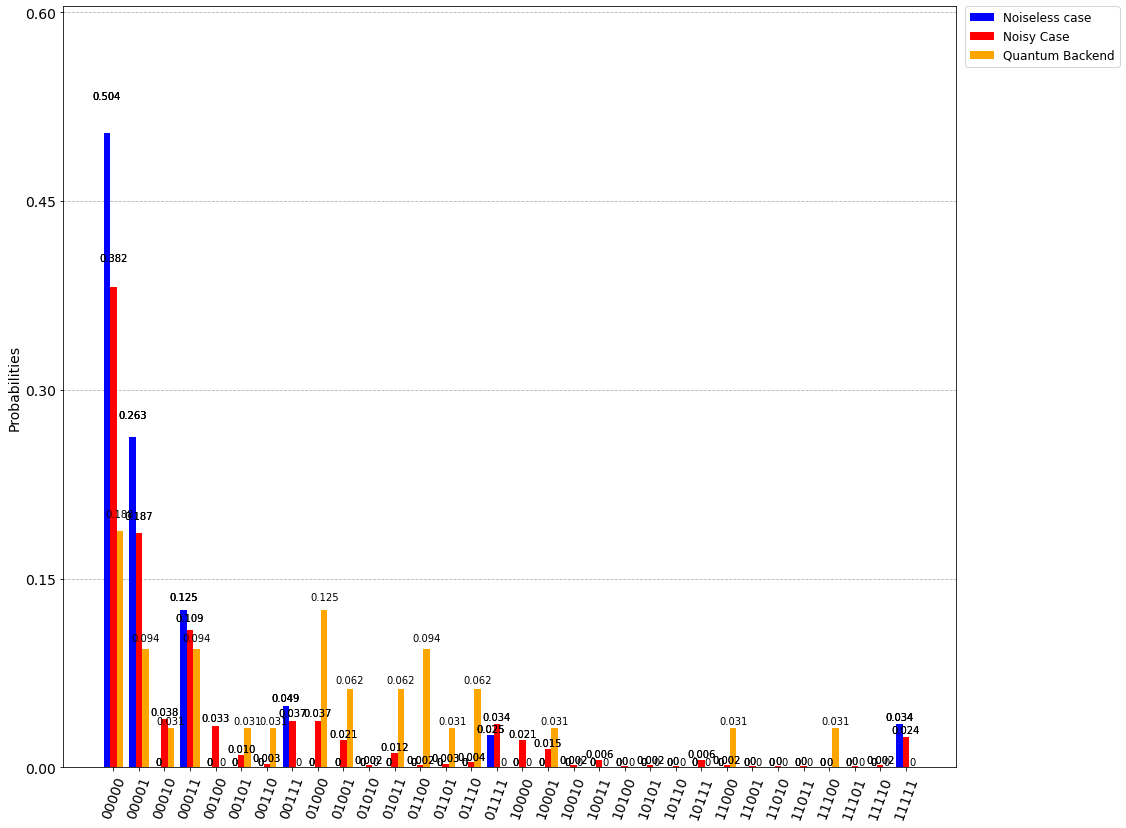

In [119]:
legend = ['Noiseless case', 'Noisy Case', 'Quantum Backend']
plot_histogram([count, count_noise, count_qc], figsize=(16,14), legend=legend, color=['blue', 'red', 'orange'])

#### This concludes this work. Thank you.